<a href="https://colab.research.google.com/github/CecinestpasJonatan/CIFAR100_Project/blob/main/MachineLearningIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What is machine learning? What is AI? These are question which are commonly discussed amongst academics and will be outside of the scope of this notebook. For practical purposes, machine learning will here be defined as the inferring models from data using numerical methods for the purpose of predicting the behaviour of data not present in the dataset which the model was trained on. AI will be defined as the ability of a system to behave in an intelligent manner.

Practical tips: Each code block can be run by clicking on the play button to the left of each block. All blocks can be run in sequence by clicking CTRL+F9, and as some blocks depends on definitions in the previous blocks this should always be done before rerunnig each block when doing experiments. The language that will be used is Python, the module NumPy will be used for mathematical operations, Matplotlib will be used for plotting, Sklearn and PyTorch will be used for the actual machine learning.

Lets start with an example. Lets say we have aquired measurement data and we want to use this data to generate a model which can predict how the output will change depending on the input data.

Text(0, 0.5, 'Output data')

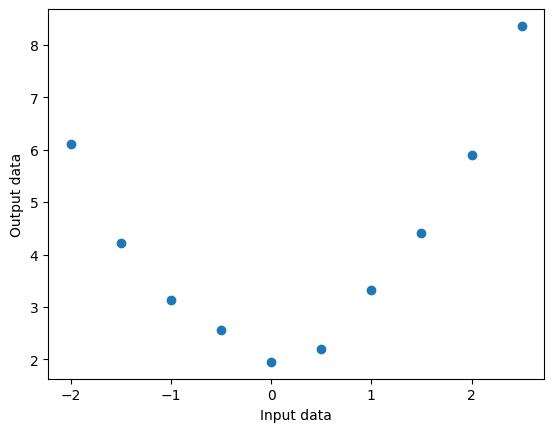

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

#Input data
x = np.linspace(-2, 2.5, 10)
#Output data (DON'T LOOK)
y = x**2 + np.random.randn(10)/5 + 2

plt.scatter(x, y)
plt.xlabel("Input data")
plt.ylabel("Output data")

Even if we don't look at the output function, our intuiton tells us that this data should be generated from some type of quadratic equation, probably with noise interferring with the measurement. Using this knowledge we go back to our first course in linear algebra and apply the least-squared method to fit a curve to our data.

Note: "@" means matrix multiplication, "a**b" means to take a to the power of b.


Text(0, 0.5, 'Output data')

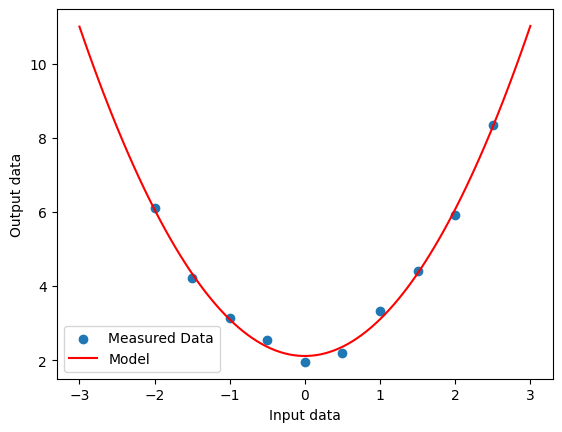

In [ ]:
#Ordinary Linear Least squares curve fitting
y_matrix = np.expand_dims(y, axis=-1)
x_matrix = np.repeat(np.expand_dims(x, axis=-1), 3, axis=-1)
x_matrix[:, 0] = 1
x_matrix[:, 2] = x_matrix[:, 2]**2
normal_matrix = x_matrix @ x_matrix.T
normal_matrix_inv = np.linalg.inv(normal_matrix)
b = np.linalg.inv(x_matrix.T@x_matrix)@x_matrix.T@y

x_model = np.linspace(-3, 3, 100)
x_model_matrix = np.repeat(np.expand_dims(x_model, axis=-1), 3, axis=-1)
x_model_matrix[:, 0] = 1
x_model_matrix[:, 2] = x_model_matrix[:, 2]**2
y_model = x_model_matrix @ b

plt.scatter(x, y, label="Measured Data")
plt.plot(x_model, y_model, label="Model", c='r')
plt.legend()

plt.xlabel("Input data")
plt.ylabel("Output data")

There we go! We have generated a model from measurement data using linear curve fitting. Now, all the matrix operations can be simplified using the NumPy library, reducing the code significantly. This method will be used in the next example.

Lets say we are unsure about the order of the polynomlial which shoud be used to fit the data. We can investigate this by testing different orders of the polynomial to see which fits the data the best.

Note: np.poly1d and np.polyfit is used to perform the steps which are done explicitly in the previous example.

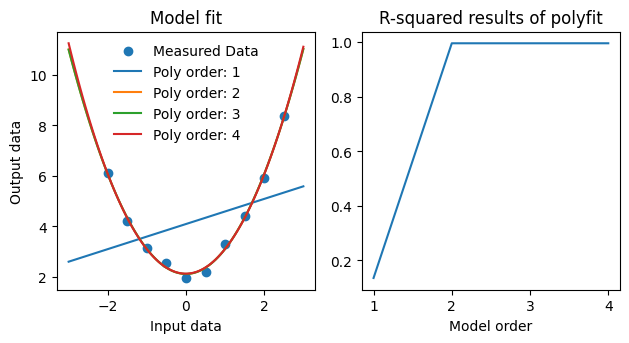

In [ ]:
#@title Code
from sklearn.metrics import r2_score

test_order= [1, 2, 3, 4]
x_model = np.linspace(-3, 3, 100)
residuals = []

fig, ax = plt.subplots(ncols=2)

ax[0].scatter(x, y, label="Measured Data")

for p_order in test_order:
  test_model = np.poly1d(np.polyfit(x, y, p_order))
  y_model = test_model(x_model)
  ax[0].plot(x_model, y_model, label=f"Poly order: {p_order}")
  residuals.append(r2_score(y, test_model(x)))

ax[0].legend(frameon=False)
ax[0].set_xlabel("Input data")
ax[0].set_ylabel("Output data")
ax[0].title.set_text('Model fit')

ax[1].plot(test_order, residuals)
ax[1].title.set_text("R-squared results of polyfit")
ax[1].set_xlabel("Model order")

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)

plt.tight_layout()

We see that polynomials of order > 1 all estimate the data pretty well, with R-squared values close to 1. However, given the nature of the data, it seems that using qubic or higher order of 2 seems like a waste. Is there a way to select models which fit the data well but is not too complicated?

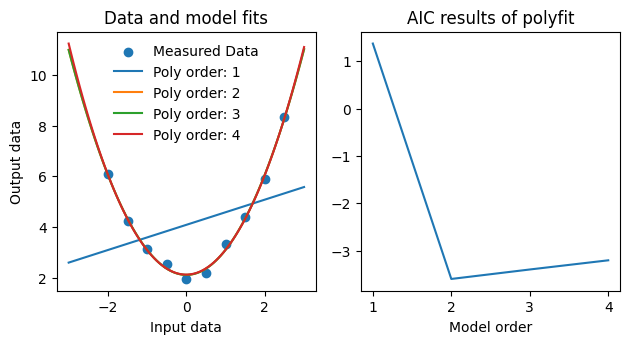

In [ ]:
#@title Code
from sklearn.metrics import r2_score

test_order= [1, 2, 3, 4]
x_model = np.linspace(-3, 3, 100)
residuals = []

fig, ax = plt.subplots(ncols=2)
ax[0].scatter(x, y, label="Measured Data")

for p_order in test_order:
  test_model = np.poly1d(np.polyfit(x, y, p_order))
  y_model = test_model(x_model)
  ax[0].plot(x_model, y_model, label=f"Poly order: {p_order}")
  res = np.sum((y - test_model(x))**2)
  aic = np.log(res/len(x)) + 2*p_order/len(x)
  residuals.append(aic)

ax[0].legend(frameon=False)
ax[0].set_xlabel("Input data")
ax[0].set_ylabel("Output data")
ax[0].title.set_text('Data and model fits')

ax[1].plot(test_order, residuals)
ax[1].title.set_text("AIC results of polyfit")
ax[1].set_xlabel("Model order")

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
plt.tight_layout()
plt.show()


In this result we see that something called AIC (Akaike Information Criterion). This is a value which measures how well a model fits the data, but which penalizes too complex models. The derivation is based in information theory and the details is not important for this example. The formula for this quantity is:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/fe67d436d9064a370cbe800b24b05ee8a68d491b)

Where k is the order of the model and L_hat is the maximum liklihood estiamtion of the data.

However, we see that this value correctly predicts that using a polynomial of order 2 is the best fit for this model.

Lets try what happens if we change the parameters of the data:

In [ ]:
#@title Code
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from sklearn.metrics import r2_score

def regression_example(p1=0, p2=1, p3=0, p4=0, noise=0.2, x_min=-2, x_max=2, n_points=10, new_points=False):
  x = np.linspace(x_min, x_max, n_points)
  y = p1*x + p2*x**2 + p3*x**3 + p4*x**4 + np.random.randn(n_points)*noise
  test_order= [1, 2, 3, 4]
  x_model = np.linspace(x_min*1.2, x_max*1.2, n_points*5)
  residuals = []
  models = []

  fig, ax = plt.subplots(ncols=2, figsize=(10, 20))
  ax[0].scatter(x, y, label="Measured Data")

  for p_order in test_order:
    test_model = np.poly1d(np.polyfit(x, y, p_order))
    y_model = test_model(x_model)
    ax[0].plot(x_model, y_model, label=f"Poly order: {p_order}")
    res = np.sum((y - test_model(x))**2)
    aic = np.log(res/len(x)) + 2*p_order
    residuals.append(aic)
    models.append(test_model)

  if new_points:
    new_data_points = x = np.linspace(x_min*1.2, x_max*1.2, int(n_points/2))
    min_aic = min(residuals)
    ind_model = residuals.index(min_aic)
    best_model = models[ind_model]

    new_y = best_model(new_data_points)
    ax[0].scatter(new_data_points, new_y, label="New data for best model", marker='x')


  ax[0].legend(frameon=False,)
  ax[0].set_xlabel("Input data")
  ax[0].set_ylabel("Output data")
  ax[0].title.set_text('Data and model fits')

  ax[1].plot(test_order, residuals)
  ax[1].title.set_text("AIC results of polyfit")
  ax[1].set_xlabel("Model order")
  ax[1].set_xticks([1,2,3,4])

  ax[0].set_box_aspect(1)
  ax[1].set_box_aspect(1)
  plt.tight_layout()
  plt.show()

output = widgets.Output()
clear_output()

widgets.interact(regression_example, p1=widgets.FloatSlider(value=1, min=-10, max=10),
                 p2=widgets.FloatSlider(value=1, min=-10, max=10),
                 p3=widgets.FloatSlider(value=0, min=-10, max=10),
                 p4=widgets.FloatSlider(value=0, min=-10, max=10),
                 noise=widgets.FloatSlider(value=0.2, min=0, max=10),
                 x_min=widgets.FloatSlider(value=-2, min=-10, max=-0.1),
                 x_max=widgets.FloatSlider(value=2, min=0.1, max=10),
                 n_points=widgets.IntSlider(value=10, min=3, max=100),
                 new_points=widgets.Checkbox(
                 value=False,
                 description='Generate new data',
                 disabled=False))

display(output)



interactive(children=(FloatSlider(value=1.0, description='p1', max=10.0, min=-10.0), FloatSlider(value=1.0, de…

Output()

One observation here is that the best AIC scoring order of the model and the order of the process which generated to the data is not always the same. This is reflected by the fact that less complex models are scored higher when there is high uncertainty in which model performs the best.

Well done! You have now done your first machine learning task. While simple, this is essentially what machine learning entails: acquring data, using the data to train a model, evaluate the model on the avaiable data and select the most appropriate model according to performance and complexity. When we have this model, that is, an estimate of the polynomial that generates the data, we can use it to generate new datapoints. This is essentially what generative AI is behind the curtain. But how do you generate an image from text? What is the model that is being fitted there? We're getting ahead of ourselves, but this is something worth considering.

Now it's time to jump ahead to more modern methods, and change the task we want to perform from estimating a certain quantity (regression) to separating the data into different groups (classification).

Imaging that we have some 2-dimensional data, which are generated from two different classes:

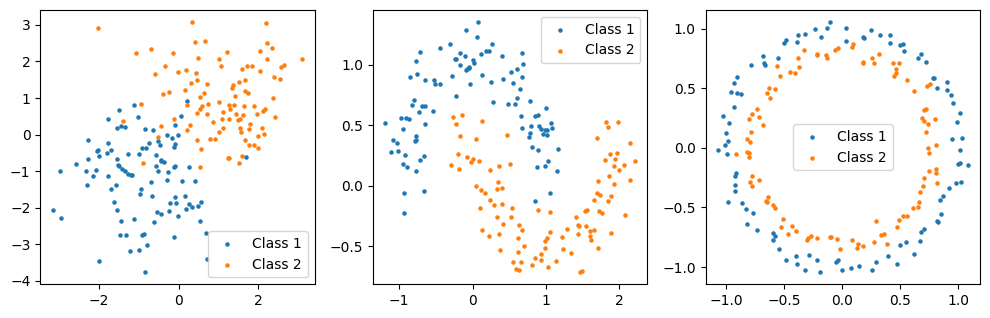

In [ ]:
#@title Code
from sklearn.datasets import make_blobs, make_moons, make_circles
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import numpy as np

n_points = 200

X_blob, y_blob = make_blobs(n_samples=n_points, centers=[[-1,-1.],[1,1]], n_features=2, random_state=1337)
X_moon, y_moon = make_moons(n_samples=n_points,  random_state=1337, noise=0.15)
X_circles, y_circles = make_circles(n_samples=n_points, random_state=1337, noise=0.04)

data = [[X_blob, y_blob],[X_moon, y_moon],[X_circles, y_circles]]

fig, axs = plt.subplots(ncols=3, figsize=(10,30))

for data_fig, ax in zip(data, axs):
  X = data_fig[0]
  y = data_fig[1]
  ax.scatter(X[y==0, 0], X[y==0, 1], s=5)
  ax.scatter(X[y==1, 0], X[y==1, 1], s=5)
  ax.legend(["Class 1", "Class 2"])
  #ax.set(aspect='equal')
  ax.set_box_aspect(1)

plt.tight_layout()

Now our task is to classify this data so that they belong to the correct class. That is, our model must be able to classify the maximum number or values as belonging to the correct class while minimizing the amount of data points which are categorized as beloning to the wrong class.

One method would be to compare each sample to a number of the closest samples, and classifying the data as beloning to the class which has the most samples beloning to a certain class in this selection of data. Example as per Wikipedia:

![image.gif](https://upload.wikimedia.org/wikipedia/commons/7/78/KNN_decision_surface_animation.gif)

Try it out in our synthetic data sets to see how the dicision boundary changes with the number of neighbors used for classification.

In [ ]:
#@title Code
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

def KNN_clf(neighbors=1):
  fig, axs = plt.subplots(ncols=3, figsize=(10,30))
  for data_fig, ax in zip(data, axs):
    X = data_fig[0]
    y = data_fig[1]
    clf = KNeighborsClassifier(n_neighbors=neighbors)
    clf.fit(X, y)

    ax.scatter(X[y==0, 0], X[y==0, 1], s=5)
    ax.scatter(X[y==1, 0], X[y==1, 1], s=5)

    y_pred = clf.predict(X)
    y_incorrect = np.argwhere(y != y_pred)

    ax.scatter(X[y_incorrect, 0], X[y_incorrect, 1], c='r', s=5)
    ax.legend(["Class 1", "Class 2", "Incorrect"])

    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
    ax.set_box_aspect(1)

  plt.tight_layout
  plt.show()

output = widgets.Output()
clear_output()

widgets.interact(KNN_clf, neighbors=widgets.IntSlider(value=5, min=2, max=15))
display(output)


interactive(children=(IntSlider(value=5, description='neighbors', max=15, min=2), Output()), _dom_classes=('wi…

Output()

This method is called K-nearest neighbors classifier, and requires no explicit training. Instead, classification is done by looking up the datapoints which are the closest the samples to be classified. While often very useful, it requires that all "training" data is stored for classifying new data points, and classifying new data points requires the model to search through all training data to find the closest data points, which can become very slow as the data set grows into the millions.

One potentially more robust method would be to find a line which can be used to divide the dataset into the different classes. However, a lot of datasets would be impossible to divide using a straight line normally, as seen in our previous examples. But here's the trick: It might be able to divide it using a straight line if the data has been transformed using some form of operation. This is commonly used trick, called the 'kernel trick', is used to transform the data, potenitally to higher dimensional representation, where the partition and classification can be performed linearly. After this decision boundary has been found the model is transformed back into the original data space, making this a very powerful method for finding complex partitions of a data set.

In the next example 'linear' means that a dicision boundary is drawn straight through the dataset without andy transformation. 'poly' means that the data is transformed using a third degree polynomial, and 'rbf' means that an exponential transform is used.

In [ ]:
#@title Code
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

def SVC_clf(kernel='linear', C=1, margin=False):

  fig, axs = plt.subplots(ncols=3, figsize=(10,30))
  for data_fig, ax in zip(data, axs):
    X = data_fig[0]
    y = data_fig[1]
    clf = svm.SVC(kernel=kernel, C=C)
    clf.fit(X, y)

    ax.scatter(X[y==0, 0], X[y==0, 1], s=5)
    ax.scatter(X[y==1, 0], X[y==1, 1], s=5)

    y_pred = clf.predict(X)
    y_incorrect = np.argwhere(y != y_pred)

    ax.scatter(X[y_incorrect, 0], X[y_incorrect, 1], c='r', s=5)
    ax.legend(["Class 1", "Class 2", "Incorrect"])

    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
    if margin:
      DecisionBoundaryDisplay.from_estimator(
          **common_params,
          response_method="decision_function",
          plot_method="contour",
          levels=[-1, 0, 1],
          colors=["k", "k", "k"],
          linestyles=["--", "-", "--"],
      )

    ax.set_box_aspect(1)

  plt.tight_layout
  plt.show()

output = widgets.Output()
clear_output()

widgets.interact(SVC_clf, kernel=widgets.RadioButtons(options=['linear', 'poly','rbf'], description='Kernel type:'), C=widgets.FloatLogSlider(value=1, base=10, min=-4, max=2, step=0.2),
    margin=widgets.Checkbox(
    value=False,
    description='Show margins',
    disabled=False))

display(output)

interactive(children=(RadioButtons(description='Kernel type:', options=('linear', 'poly', 'rbf'), value='linea…

Output()

This method of machine learning is called Support Vector Machines. This algorithm tries to find a dicision boundary between classes which minimizes the incorrectly classified data, as well as maximizing the distance between the boundary and incorrectly classified samples. These samples that lies on the edge of this margin between partitions are called support vectors. Here we see that it's not possible to find a straight line which partitions the data into two parts without incorrectly classify any data, but using kernel transformations it is possible to partition the data accurately. The most common kernel transformation is called 'rbf', or 'radial basis function', which can be seen as a infinite dimensional polynomial transformation. This function defines the distance between two data points as:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/c16fd6c515412f96a57506103896178d0e8af77d)

The 'C' parameter determines how much the algorithm will 'punish' incorretly labeled data, meaning that a high 'C' value will nudge the algorithm towards finding a more complex decision boundary.

One problem with this algorithm is that it does not scale well with increasing data samples and dimensions, as well as needing to decide what type of kernel to use for data transformations with no flexibility for different parts of the dataset. Evidently, a more expressive method which can approximate functions for different parts of the dataset separably is need.


One method of partitioning the dataset into different parts is to build a decision tree. Using this method the model tries to learn different hierarchies of partitions of the dataset which can be used in the end to classify different data samples. One example per wikipedia in how such a tree can look like:

![titanic.png](https://upload.wikimedia.org/wikipedia/commons/e/eb/Decision_Tree.jpg)

'sibsp' here referes to the number of sibling aboar the Titanic. Here the algorithm has learned that the most important factor in surviving is whether you are male or female. Then, if you are male, the most important factor is your age, and after that the most important factor is the number of siblings aboard. Note that this hierarchy is dependent on the constraints in the depth of the tree, how many datapoints are needed to split a tree, and how many datapoints are needed to become a leaf point.

The decision tree method, as we see, uses a number of parameters to decide how to build the descision tree, where the max_depth parameter decides the maximum level of decision that the tree can consist of, while min_split and min_leaf decides how many data samples are needed for a decision to be made at each node and lead, respectively. Increasing the maximum depth will enable the decision tree to model more complex data, while increasing the min_split and min_leaf values will make the classification "safe", i.e. the algorithm will look at larger clusters of data instead of single data points.

In [ ]:
#@title Code
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

def Tree_clf(max_depth=None, min_samples_split=2, min_samples_leaf=1):
  fig, axs = plt.subplots(ncols=3, figsize=(10,30))
  for data_fig, ax in zip(data, axs):
    X = data_fig[0]
    y = data_fig[1]
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf.fit(X, y)

    ax.scatter(X[y==0, 0], X[y==0, 1], s=5)
    ax.scatter(X[y==1, 0], X[y==1, 1], s=5)

    y_pred = clf.predict(X)
    y_incorrect = np.argwhere(y != y_pred)

    ax.scatter(X[y_incorrect, 0], X[y_incorrect, 1], c='r', s=5)
    ax.legend(["Class 1", "Class 2", "Incorrect"])

    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
    ax.set_box_aspect(1)

  plt.tight_layout
  plt.show()

output = widgets.Output()
clear_output()

widgets.interact(Tree_clf, max_depth=widgets.IntSlider(value=5, min=0, max=50, description='Max_depth'),
                 min_samples_split=widgets.IntSlider(value=2, min=2, max=50, description='Min_split:'),
                 min_samples_leaf=widgets.IntSlider(value=1, min=1, max=50, description='Min_leaf'),)
display(output)


interactive(children=(IntSlider(value=5, description='Max_depth', max=50), IntSlider(value=2, description='Min…

Output()

But what if we want to both partition the dataset into different parts, and still use some form of function to models the individual parts of the dataset?

One way of expressing arbitrary functions is to use mulitple layers of individual estimators, which are combined to produce the final estimation. These estimators are able to partition the dataset into subfields where they contribute to the esimation if active, otherwise they will remain inactive. This allows for non-linear estimation while enabling training gradually by comparing individual or a subset of samples to the correct data:

In [ ]:
#@title Code

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

def get_activations(clf, X, y):
  l1 = (clf.coefs_[0].T@X.T).T + clf.intercepts_[0].T
  l1_mask = l1 > 0
  l1_act = l1 * l1_mask

  l2 = (clf.coefs_[1].T@l1_act.T).T + clf.intercepts_[1]
  l2_mask = l2 > 0
  l2_act = l2 * l2_mask

  output = (clf.coefs_[2].T@l2_act.T).T + clf.intercepts_[2]
  return l1_act, l2_act, output

def MLP_clf(layer1=10, layer2=10, learning_rate=0.05, iterations=100):
  fig, axs = plt.subplots(ncols=3, figsize=(10,30))
  clf_base = MLPClassifier(hidden_layer_sizes=(layer1, layer2), learning_rate_init=learning_rate,
                      learning_rate='invscaling', random_state=1337, warm_start=True,
                      activation='relu', max_iter=iterations)
  clf_list = [clone(clf_base), clone(clf_base), clone(clf_base)]
  for data_fig, ax, clf in zip(data, axs, clf_list):
    X = data_fig[0]
    y = data_fig[1]
    clf.fit(X, y)

    ax.scatter(X[y==0, 0], X[y==0, 1], s=5)
    ax.scatter(X[y==1, 0], X[y==1, 1], s=5)

    y_pred = clf.predict(X)
    y_incorrect = np.argwhere(y != y_pred)

    ax.scatter(X[y_incorrect, 0], X[y_incorrect, 1], c='r', s=5)
    ax.legend(["Class 1", "Class 2", "Incorrect"])

    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
                **common_params,
                response_method="predict",
                plot_method="pcolormesh",
                alpha=0.3,)
    ax.set_box_aspect(1)

  plt.tight_layout
  plt.show()

output = widgets.Output()
clear_output()

widgets.interact(MLP_clf, layer1=widgets.IntSlider(value=10, min=1, max=50),
                 layer2=widgets.IntSlider(value=10, min=1, max=50),
                 learning_rate=widgets.FloatLogSlider(value=0.05, base=10, min=-3, max=0, step=0.2),
                 iterations=widgets.IntSlider(value=200, min=1, max=500),)
display(output)


interactive(children=(IntSlider(value=10, description='layer1', max=50, min=1), IntSlider(value=10, descriptio…

Output()

This is exactly what neural networks do! The architecture of the network allows for extremely powerful estimations, while being relatively "cheap" to train. This example uses a intial two layer neural network with 10 neurons each using the Sklearn module, but usually this is done using more specialized libraries which provide a vast amount of options on how to constuct and train these networks.

Almost all deep neural networks are trained using a method called Gradient Descent, and adjusting the parameters for each layer is done using a method called back-propagation. Put simply, this method trains the network iteratively by comparing the results as inferred from the model to the actual truth, and slightly adjusting the parameters to predict the correct results for each sample. How much the network corrects its prediction for each sample is called the learning rate, and needs to be chosen carefully to ensure that network doesn't "overcorrect" for each individual sample, but still corrects it enough so that is can learn to predict correcly without excessive number of iterations.

A large amount of modern machine learning models are based in part or fully on neural network architectures. Going forward in this notebook we will focus on how to train these neural networks for different tasks.

Lets try a even more current example:

A common machine learning task is to identify written symbols in order to transcribe images. A common dataset to use to illustrate this is called the MNIST dataset, which consists of 70000 handwritten images of numbers. We will now see if we can use deep learning to identify these handwritten numbers.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.7MB/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.24MB/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.13MB/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.58MB/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



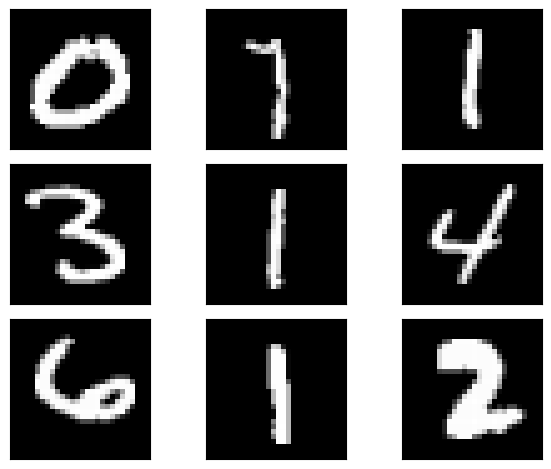

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

batch_size_train = 64
batch_size_test = batch_size_train

train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                               (0.1307,), (0.3081,))
                               ])), batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                                          transform=torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(
                                          (0.1307,), (0.3081,))
                                          ])),batch_size=batch_size_test, shuffle=True)


examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()